## Step 4 — Prepare Pretrained GoogLeNet Model

In this step, we:
1. Load the pretrained GoogLeNet model from `torchvision.models`
2. Replace its fully connected (FC) layer with a custom classifier
   suitable for the number of blood cancer cell classes in our dataset

> Note: At this stage, we are **preparing the model**, not yet training or fine-tuning.


In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# === Paths ===
train_dir = "../data/part_one_data/train"
val_dir = "../data/part_one_data/val"

# === Device setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Load pretrained googlenet ===
model = models.googlenet(pretrained=False, aux_logits=False)


# === Freeze early layers (optional) ===
for param in model.parameters():
    param.requires_grad = False

# === Replace final fully connected layer ===
model.fc = nn.Sequential(
    nn.Linear(1024, 512),   # première couche fully connected
    nn.ReLU(),              # fonction d’activation
    nn.Dropout(0.20),        # éviter le sur-apprentissage
    nn.Linear(512, 256),  # sortie = nb de classes 
    nn.ReLU(),
    nn.Dropout(0.10),  
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.10),  
    nn.Linear(128, 4)
    
)
model = model.to(device)

# === Define image transformations ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === Load datasets ===
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")


Using device: cuda
Training samples: 2740 | Validation samples: 484
Classes: ['Benign', 'Pre-B', 'Pro-B', 'early Pre-B']


c:\Users\ycode\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ycode\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\ycode\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


##  Step 5 — Define Optimizer, Loss Function & Training Loop

In this step, we will:

1. Define the **loss function** suitable for multi-class classification (`CrossEntropyLoss`)  
2. Choose an **optimizer** (Adam or SGD) and learning rate  
3. Implement a **training loop** to train the model on the training set and evaluate on the validation set  

> Note: The model architecture is already prepared (GoogLeNet with custom FC layer).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# Model setup (main change)
# Disabled aux heads for cleaner gradients

model = models.googlenet(pretrained=False, aux_logits=False)
model.fc = nn.Sequential(
    nn.Linear(1024, 512),   # première couche fully connected
    nn.ReLU(),              # fonction d’activation
    nn.Dropout(0.20),        # éviter le sur-apprentissage
    nn.Linear(512, 256),  # sortie = nb de classes 
    nn.ReLU(),
    nn.Dropout(0.20),  
    nn.Linear(256, 128),
    # nn.ReLU(),
    # nn.Linear(128, 4)
)
model = model.to(device)

#  Hyperparameters (tuned)
# Reduced epochs, added weight decay, kept moderate LR

num_epochs = 25
learning_rate = 1.5e-4
patience = 5                  # Early stopping patience
weight_decay = 1e-4           # L2 regularization
best_model_path = "../US3_training_evaluation_pytorch/models/best_model.pth"


#  Loss and optimizer setup
# Using Adam for stability + scheduler for smoother convergence

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

#  Metrics & early stopping

train_loss_history, val_loss_history, val_acc_history = [], [], []
best_val_acc = 0.0
epochs_no_improve = 0

#  Training loop

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / total

    #  Validation

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total
    scheduler.step(val_loss)  

    # Store metrics

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

    # Early stopping check

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated at epoch {epoch+1}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n Early stopping triggered at epoch {epoch+1}")
            break


print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best model saved at: {best_model_path}")


Epoch [1/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.37it/s]


Epoch [1/25] Train Loss: 1.0610 | Val Loss: 1.2033 | Val Acc: 67.98%
Best model updated at epoch 1


Epoch [2/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.35it/s]


Epoch [2/25] Train Loss: 0.1620 | Val Loss: 3.4242 | Val Acc: 36.98%


Epoch [3/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.37it/s]


Epoch [3/25] Train Loss: 0.1436 | Val Loss: 0.4561 | Val Acc: 77.89%
Best model updated at epoch 3


Epoch [4/25] Training: 100%|██████████| 86/86 [00:37<00:00,  2.32it/s]


Epoch [4/25] Train Loss: 0.1197 | Val Loss: 0.3504 | Val Acc: 86.16%
Best model updated at epoch 4


Epoch [5/25] Training: 100%|██████████| 86/86 [00:37<00:00,  2.31it/s]


Epoch [5/25] Train Loss: 0.0873 | Val Loss: 1.2379 | Val Acc: 75.83%


Epoch [6/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.35it/s]


Epoch [6/25] Train Loss: 0.0745 | Val Loss: 0.0631 | Val Acc: 97.73%
Best model updated at epoch 6


Epoch [7/25] Training: 100%|██████████| 86/86 [00:37<00:00,  2.29it/s]


Epoch [7/25] Train Loss: 0.0743 | Val Loss: 1.2936 | Val Acc: 71.90%


Epoch [8/25] Training: 100%|██████████| 86/86 [00:37<00:00,  2.30it/s]


Epoch [8/25] Train Loss: 0.0508 | Val Loss: 0.0919 | Val Acc: 97.73%


Epoch [9/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.35it/s]


Epoch [9/25] Train Loss: 0.0853 | Val Loss: 0.2057 | Val Acc: 92.98%


Epoch [10/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.34it/s]


Epoch [10/25] Train Loss: 0.0357 | Val Loss: 0.0192 | Val Acc: 99.38%
Best model updated at epoch 10


Epoch [11/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.36it/s]


Epoch [11/25] Train Loss: 0.0425 | Val Loss: 0.2523 | Val Acc: 91.32%


Epoch [12/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.37it/s]


Epoch [12/25] Train Loss: 0.0310 | Val Loss: 0.0434 | Val Acc: 98.55%


Epoch [13/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.36it/s]


Epoch [13/25] Train Loss: 0.0216 | Val Loss: 0.0931 | Val Acc: 97.93%


Epoch [14/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.36it/s]


Epoch [14/25] Train Loss: 0.0321 | Val Loss: 0.0181 | Val Acc: 99.59%
Best model updated at epoch 14


Epoch [15/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.34it/s]


Epoch [15/25] Train Loss: 0.0141 | Val Loss: 0.0134 | Val Acc: 99.38%


Epoch [16/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.35it/s]


Epoch [16/25] Train Loss: 0.0185 | Val Loss: 0.0300 | Val Acc: 99.38%


Epoch [17/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.38it/s]


Epoch [17/25] Train Loss: 0.0128 | Val Loss: 0.0183 | Val Acc: 99.59%


Epoch [18/25] Training: 100%|██████████| 86/86 [00:36<00:00,  2.33it/s]


Epoch [18/25] Train Loss: 0.0116 | Val Loss: 0.0136 | Val Acc: 99.59%


Epoch [19/25] Training: 100%|██████████| 86/86 [00:37<00:00,  2.31it/s]


Epoch [19/25] Train Loss: 0.0081 | Val Loss: 0.0120 | Val Acc: 99.38%

 Early stopping triggered at epoch 19

Training complete! Best validation accuracy: 99.59%
Best model saved at: ../US3_training_evaluation_pytorch/models/best_model.pth


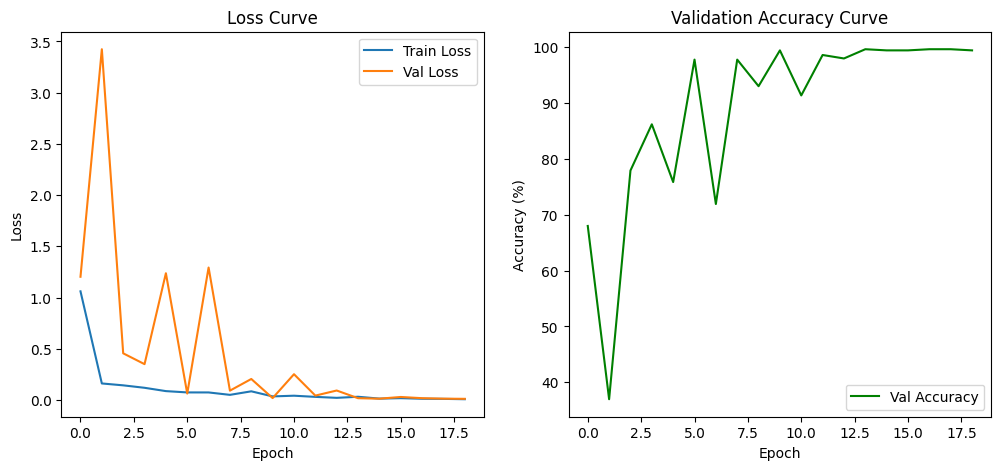

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# --- Loss curve ---
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Accuracy curve ---
plt.subplot(1,2,2)
plt.plot(val_acc_history, label='Val Accuracy', color='green')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [6]:
# --- Save model ---

model_save_path = "../US3_training_evaluation_pytorch/models/best_model.pth"
torch.save(model, model_save_path)
print(f" Model saved to {model_save_path}")




 Model saved to ../US3_training_evaluation_pytorch/models/best_model.pth
